In [1]:
# Import the required packages.

from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, validation_curve
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc 
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Reading data

mnist = load_digits()
mnist.data.shape

(1797, 64)

In [3]:
# Using the zip function, placed the pixels of each image alongside its corresponding label in a list.
image_and_labels = list(zip(mnist.images, mnist.target))

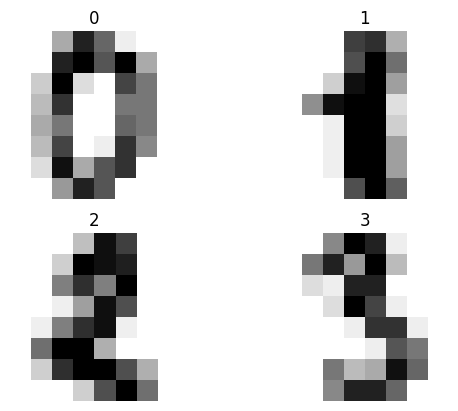

In [4]:
"""The mnist.images dataset returns an np.ndarray containing the pixel values of each image,
which can be visualized using the plt.imshow() function.
"""

# Display first 4 images in a 2x2 grid

for idx, (image, target) in enumerate(image_and_labels[:4]):
    plt.subplot(2, 2, idx + 1) # 2x2 grid for 4 images
    plt.imshow(image, cmap=plt.cm.gray_r) # Grayscale visualization
    plt.title(target) # Show label as title
    plt.axis("off") # Hide axes for cleaner display

In [5]:
# Converting each image from a 2D matrix to a 1D vector.

X = mnist.data.reshape(len(mnist.data), -1)
Y = mnist.target

In [6]:
# Data classification for training and testing.

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=1)

In [7]:
# Create a model and train it with training data.

model = SVC(probability=True)
model.fit(x_train, y_train)
y_pred_proba = model.predict_proba(x_test)

In [8]:
# Test the model and store the results in the variable results.

results = model.predict(x_test)

In [9]:
# The classification report shows the lowest performance is for digits 8 and 9.

print(classification_report(results, y_test))

              precision    recall  f1-score   support

           0       0.98      1.00      0.99        58
           1       1.00      0.98      0.99        50
           2       1.00      0.98      0.99        50
           3       0.98      1.00      0.99        63
           4       1.00      0.98      0.99        62
           5       0.98      0.96      0.97        48
           6       1.00      1.00      1.00        51
           7       0.98      1.00      0.99        56
           8       0.96      1.00      0.98        44
           9       0.96      0.95      0.96        58

    accuracy                           0.99       540
   macro avg       0.99      0.99      0.98       540
weighted avg       0.99      0.99      0.99       540



In [10]:
confusion_matrix(results, y_test)

array([[58,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 49,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0, 49,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 63,  0,  0,  0,  0,  0,  0],
       [ 1,  0,  0,  0, 61,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 46,  0,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  0, 51,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 56,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 44,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  1,  1, 55]])

The model's accuracy is 98%.

In [11]:
print(accuracy_score(y_test, results))

0.9851851851851852


In [12]:
"""calculate ROC curve for model
don't know what is roc curve? check documentaion
"""

# Convert multi-class labels to binary format using one-hot encoding
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

# Calculate ROC Metrics for Each Class

fpr = dict() # False Positive Rate
tpr = dict() # True Positive Rate
roc_auc = dict() # Area Under Curve

for i in range(10):  # For each digit class 0-9
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

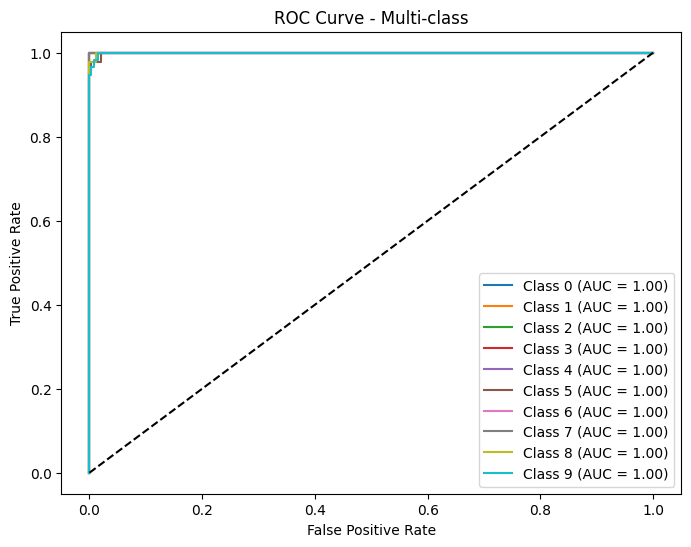

In [13]:
# Visualizatio

plt.figure(figsize=(8, 6))
for i in range(10):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Multi-class')
plt.legend()
plt.show()

In [14]:
"""I want to create a new model, tune its hyperparameters, and evaluate changes in performance.
In the following three cells, i aim to determine the optimal value for the 'C' parameter.
"""

param_range = np.logspace(-4, 4, 10)  # C values from 0.0001 to 10000
# Use validation_curve
train_scores, val_scores = validation_curve(
    estimator=SVC(),                    # Your SVC model
    X=x_train,                         # Your training features
    y=y_train,                         # Your training labels
    param_name='C',                    # Parameter to vary
    param_range=param_range,           # Range of C values to test
    cv=5,                             # 5-fold cross-validation
    scoring='accuracy',               # Metric to evaluate
    n_jobs=-1                         # Use all CPU cores
)

In [15]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

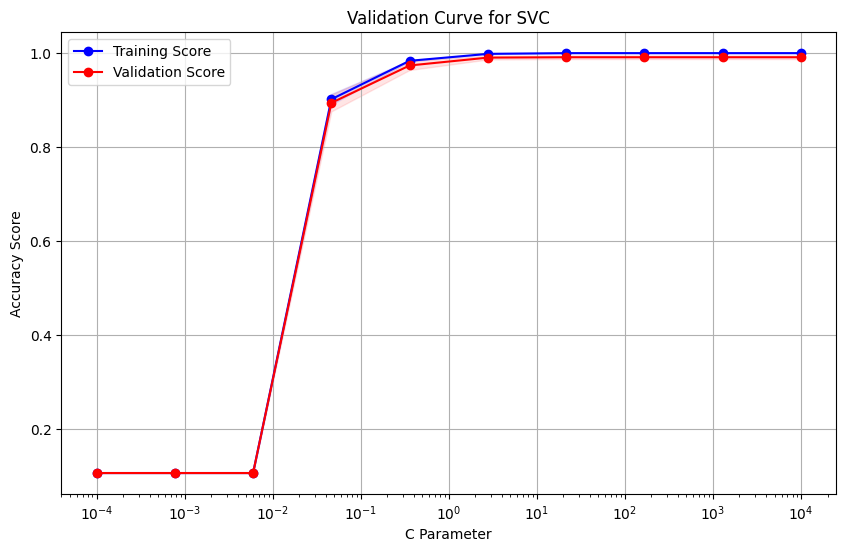

In [16]:
plt.figure(figsize=(10, 6))
plt.plot(param_range, train_mean, 'o-', color='blue', label='Training Score')
plt.fill_between(param_range, train_mean - train_std, train_mean + train_std, 
                 alpha=0.1, color='blue')

plt.plot(param_range, val_mean, 'o-', color='red', label='Validation Score')
plt.fill_between(param_range, val_mean - val_std, val_mean + val_std, 
                 alpha=0.1, color='red')

plt.xlabel('C Parameter')
plt.ylabel('Accuracy Score')
plt.title('Validation Curve for SVC')
plt.legend()
plt.xscale('log')  # Since C values are often log-spaced
plt.grid(True)
plt.show()

In [17]:
# this is the second model
new_model = SVC(
    C=2,
    class_weight='balanced'
)

In [18]:
new_model.fit(x_train, y_train)

,C,2
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,'balanced'
,verbose,False


In [19]:
new_results = new_model.predict(x_test)
print(classification_report(new_results, y_test))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        59
           1       1.00      0.98      0.99        50
           2       1.00      0.98      0.99        50
           3       0.98      1.00      0.99        63
           4       1.00      1.00      1.00        61
           5       0.98      0.96      0.97        48
           6       1.00      1.00      1.00        51
           7       0.98      1.00      0.99        56
           8       0.98      1.00      0.99        45
           9       0.96      0.96      0.96        57

    accuracy                           0.99       540
   macro avg       0.99      0.99      0.99       540
weighted avg       0.99      0.99      0.99       540



In [20]:
confusion_matrix(new_results, y_test)

array([[59,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 49,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0, 49,  1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 63,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 61,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0, 46,  0,  0,  0,  2],
       [ 0,  0,  0,  0,  0,  0, 51,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 56,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0, 45,  0],
       [ 0,  0,  0,  0,  0,  1,  0,  1,  0, 55]])

In [21]:
"""Based on validation curve analysis, C=2 chosen for optimal performance.
See documentation for detailed explanation
"""
print(accuracy_score(y_test, new_results))

0.9888888888888889
